In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.transforms as mtransforms

plt.rc('figure', facecolor='w')
plt.rc('font', size=11)

DT_GH = 1
RT = 0.0019872 * 300

In [2]:
data = np.moveaxis([np.loadtxt(f'data/YOPH_gh/{i+1}.gh') for i in range(60)], 2, 0)

In [3]:
keys = ('mass', 'full', 'solvent', 'protein_intra', 'only_cmap', 'only_torsions')
data_dict = {k: v for k, v in zip(keys, data)}
data_dict['all_torsions'] = data_dict['only_torsions'] + data_dict['only_cmap']

In [4]:
m = np.mean(data_dict['mass'])

In [5]:
def get_autocorr(f, m, rt):
    beta = 1. / rt
    y_raw = np.correlate(f, f, 'same')
    y = y_raw[len(y_raw) // 2:] / np.arange(len(f), len(f) // 2, -1)
    return y * beta / m * 4.184E26


def get_mean_autocorr(f, m, rt):
    return np.mean(np.array([get_autocorr(_, m, rt) for _ in f]), axis=0)


def remove_mean(x):
    return x - np.mean(x, axis=1)[:, None]

xi_dict = {k: get_mean_autocorr(remove_mean(f), m, RT) 
           for k, f in data_dict.items()}

In [7]:
acf_ps_dict = {k: np.abs(np.fft.rfft(v))**2 for k, v in xi_dict.items()}

In [10]:
names_dict = {'full': 'full',
              'solvent': 'solvent',
              'protein_intra': 'intramolecular (protein)',
              'all_torsions': 'torsions (all)',
              'only_cmap': 'torsions (backbone)',
              'only_torsions': 'torsions (sidechain)'}

colors_dict = {'full': 'grey',
              'solvent': 'blue',
              'protein_intra': 'red',
              'all_torsions': 'purple',
              'only_cmap': 'green',
              'only_torsions': 'orange'}

def plot_a(ax):
    x = np.arange(len(xi_dict['full'])) * DT_GH

    for key in ('full', 'solvent', 'protein_intra'):
        ax.plot(x, xi_dict[key] *1E-30, lw=2, label=names_dict[key], c=colors_dict[key])

    ax.set_xlim([0, 500])
    ax.set_xlabel('Time (fs)')
    ax.set_ylabel('$\\xi$ (fs$^{-2}$)')
    ax.legend()

In [11]:
def plot_b(ax):
    x = np.arange(len(acf_ps_dict['full'])) * 1.0E11 / 2.9979E10 #cm^-1
    for key in ('full', 'all_torsions', 'only_cmap', 'only_torsions'):
        ax.plot(x[1:], acf_ps_dict[key][1:] * 1.E-60, lw=2, 
                label=names_dict[key], c=colors_dict[key])
    ax.set_xlim([0, 1000])
    ax.set_ylim([0, 1.0])
    ax.set_xlabel('Freq ($cm^{-1}$)')
    ax.set_ylabel('PS($\\xi$) (fs$^{-4}$)')
    ax.legend()

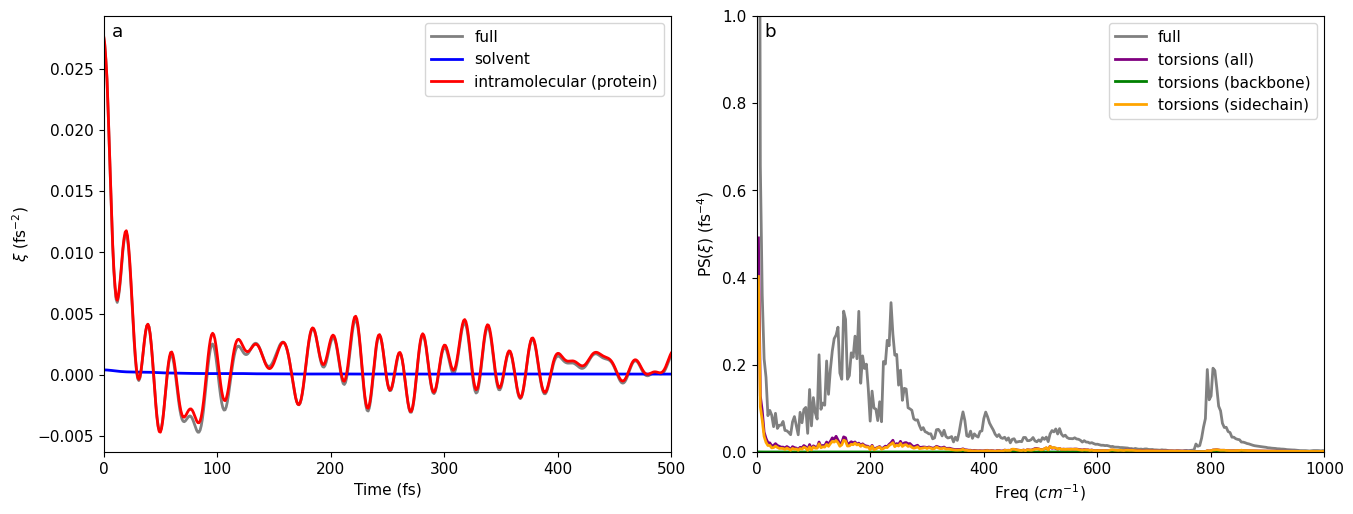

In [12]:
fig, axs = plt.subplot_mosaic([['a', 'b']], figsize=(13,5))
fig.tight_layout()
plt.subplots_adjust(wspace=0.15)
plot_a(axs['a'])
plot_b(axs['b'])

for label, ax in axs.items():
    trans = mtransforms.ScaledTranslation(10/72, -5/72, fig.dpi_scale_trans)
    ax.text(-0.01, 1.0, label, transform=ax.transAxes + trans, 
            verticalalignment='top', fontsize='large')
plt.savefig('FigE2.png', dpi=300, bbox_inches='tight')
plt.show()